# Support Vector Classifier Strategy Code

In this notebook, you will learn to use the support vector classifier (SVC) algorithm and its step by step implementation on S&P500. 

SVCs are supervised learning models. A set of training data is provided to the SVC algorithm, each belonging to one of the  categories. For instance, the categories can be either to buy or to sell a stock. The algorithm builds a model during training phase and assigns new data into one of the categories based on the model crated during the training phase.

In [1]:
# Machine learning
from sklearn.svm import SVC
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

# For data manipulation
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn

In [2]:
def bollinger_bands (data, n): 
    
    # Calculating the moving average
    MA = data['close'].rolling(window=n).mean() 
    # MA = pd.rolling_mean(data['Close'],n)

    
    # Calculating the standard deviation
    SD = data['close'].rolling(window=n).std() 
    # SD = pd.rolling_std(data['Close'],n)

    data['lower_bb'] = MA - (2 * SD) # Lower Bollinger Band
    data['upper_bb'] = MA + (2 * SD) # Upper Bollinger Band
   
    return data

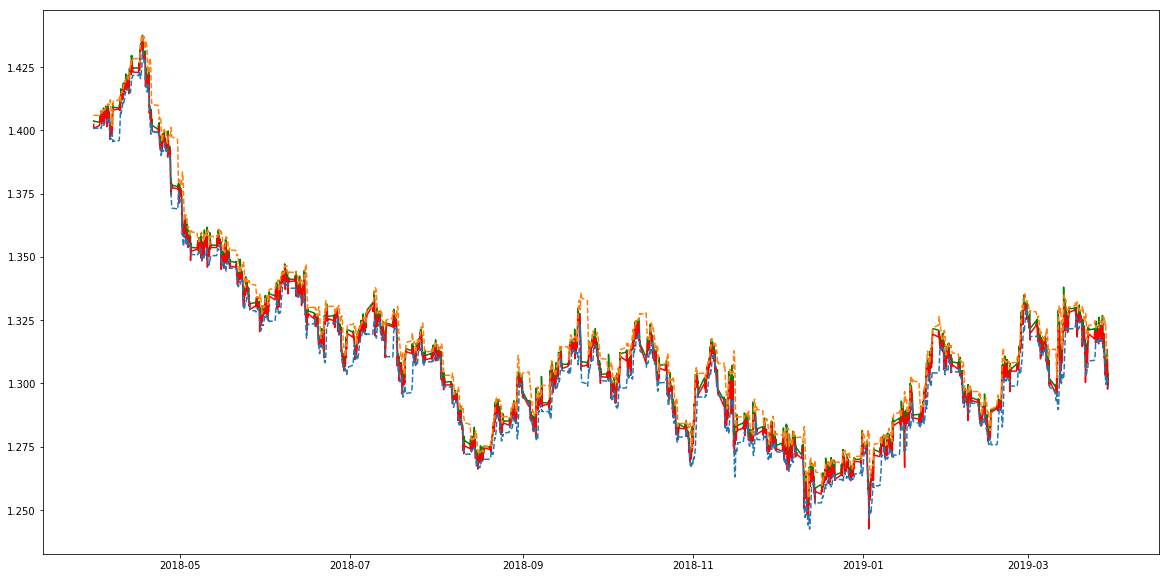

In [3]:
df = pd.read_csv ('./CSV/GBPUSD_Candlestick_1_Hour_BID_30.03.2018-30.03.2019.csv')
#df = df.iloc[750:800] 
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace=True)
df = bollinger_bands (df, 21)
df = df.dropna()

plt.figure(figsize=(20,10))
plt.plot(df.high, color ='green')
plt.plot(df.low, color ='red')
plt.plot(df.lower_bb, linestyle='dashed')
plt.plot(df.upper_bb, linestyle='dashed')

#plt.grid(True)
#plt.ylabel("EUR_USD Rate")
plt.show()

# Determine the correct trading signal

If tomorrow's price is greater than today's price then we will buy, else sell. We will store +1 for buy signal and -1 for sell signal in Signal column.

#### y is a target dataset storing the correct trading signal which the machine learning algorithm will try to predict.

In [4]:
y = np.where(df['close'].shift(-1) > df['close'],1,-1)

# Creation of predictors datasets

The X is a dataset that holds the variables which are used to predict y, that is, whether the S&P500 index price will go up (1) or go down (-1) tomorrow. The X consists of variables such as 'Open - Close' and 'High - Low'. These can be understood as indicators based on which the algorithm will predict tomorrow's trend. Feel free to add mroe indicators and see the performance.

In [5]:
df['open - close'] = df.open - df.close
df['high - low'] = df.high - df.low
df['touched_lbb'] = (df.lower_bb > df.low).astype(int)
df['touched_ubb'] = (df.upper_bb <= df.high).astype(int)
X=df[['open - close','high - low']]
X.head()

,open - close,high - low
date,,
2018-03-30 21:00:00,-0.00020,0.00138
2018-03-30 22:00:00,0.00198,0.00273
2018-04-01 23:00:00,-0.00049,0.00135
2018-04-02 00:00:00,-0.00059,0.00130
2018-04-02 01:00:00,-0.00028,0.00085


# Test and train data set split

Now, we will split data into training and test data set. 

1. First 80% of data is used for training and remaining data for testing.
2. X_train and y_train are training dataset.
3. X_test and y_test are test dataset.

In [6]:
split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split] 

# Test data set
X_test = X[split:]
y_test = y[split:]

# Support Vector Classifier (SVC)

We will use SVC() function from sklearn.svm.SVC library for the classification and create our classifier model using fit() method on the training data set.

In [7]:
cls = SVC().fit(X_train, y_train)

/home/rod/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Classifier accuracy
We will compute the accuarcy of the algorithm on the train and test data set, by comparing the actual values of Signal with the predicted values of Signal. The function accuracy_score() will be used to calculate the accuracy.

<B>Syntax:</B> accuracy_score(<font color=blue>target_actual_value</font>,<font color=blue>target_predicted_value</font>)
1. <font color=blue>target_actual_value:</font> correct signal values
2. <font color=blue>target_predicted_value:</font> predicted signal values

In [8]:
accuracy_train = accuracy_score(y_train, cls.predict(X_train))
accuracy_test = accuracy_score(y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 51.23%
Test Accuracy: 51.16%


# Prediction

### Predict signal 

We will predict the signal (buy or sell) for the test data set, using the cls.predict() fucntion.

### Compute returns in test period

We will compute the strategy returns based on the predicted signal, and then save it in the column 'Strategy_Return' and plot the cumulative strategy returns.

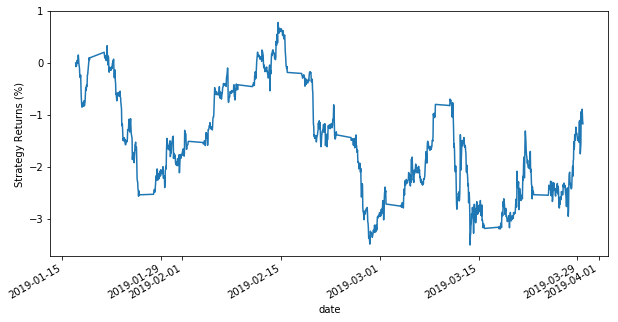

In [9]:
df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.close.shift(-1) / df.close)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [12]:
df['Strategy_Return'] = df.Return * df.Predicted_Signal

df.head()

,open,high,low,close,volume,lower_bb,upper_bb,open - close,high - low,touched_lbb,touched_ubb,Predicted_Signal,Return,Strategy_Return
date,,,,,,,,,,,,,,
2018-03-30 21:00:00,1.40270,1.40381,1.40243,1.40290,8198.2402,1.401067,1.405825,-0.00020,0.00138,0,0,-1,-0.144091,0.144091
2018-03-30 22:00:00,1.40286,1.40361,1.40088,1.40088,4492.7798,1.400782,1.405968,0.00198,0.00273,0,0,-1,0.131973,-0.131973
2018-04-01 23:00:00,1.40224,1.40328,1.40193,1.40273,704.7800,1.400987,1.405890,-0.00049,0.00135,0,0,-1,0.039914,-0.039914
2018-04-02 00:00:00,1.40270,1.40333,1.40203,1.40329,3268.3999,1.401053,1.405893,-0.00059,0.00130,0,0,-1,0.018526,-0.018526
2018-04-02 01:00:00,1.40327,1.40379,1.40294,1.40355,2396.4099,1.401101,1.405910,-0.00028,0.00085,0,0,-1,0.076918,-0.076918
